## Face Recognition - 05/06/2020

Image detection using inception module. For creating and training model refer to: <a href="https://github.com/khushig712/Face-Recognition/blob/master/one-by-one%20test/facenet-model_20200605.ipynb">facenet-model_20200605.ipynb</a>

In [3]:
import cv2

In [4]:
import tensorflow as tf
import pathlib
import numpy as np
import os
import cv2
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as pyplot
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from skimage import transform
from keras.preprocessing import image

%matplotlib inline

Using TensorFlow backend.


In [5]:
data_dir='./cropped/train/'   #path of training directory
data_dir = pathlib.Path(data_dir)

data_dr='./cropped/valid/'    #path of valid_set directory
data_dr = pathlib.Path(data_dr)

image_count = len(list(data_dir.glob('*/*.jpg')))

# generator for training set and valid set. The training data generator employs data augmentation in form of flips and zooms.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# name of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt', 'Irrfan_Khan',
       'Jen_Aniston', 'Jen_Lawrence', 'Johnny_Depp', 'Pankaj_Tripathi',
       'Robert_DowneyJr', 'Will_Smith'], dtype='<U18')

In [7]:
#iterable form of generators

train_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

valid_data_gen = image_generator.flow_from_directory(directory=str(data_dr),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1295 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [8]:
images,labels=next(train_data_gen)
x_test,y_test=next(valid_data_gen)

In [9]:
model=load_model('./inception.h5')

In [11]:
image_dir_basepath = './images/train/'
names = CLASS_NAMES
image_size = 160

In [53]:
test_dirpath = os.path.join('./images/test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [54]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# draw each face separately
def draw_faces(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    fig, axes = pyplot.subplots(1,1, figsize=(5, 2))
    axes.imshow(data)
    h,w,c=data.shape
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        np_image = data[y1:y2,x1:x2]
        np_image = np.array(np_image).astype('float32')/255
        np_image = transform.resize(np_image, (224, 224, 3))
        img = np.expand_dims(np_image, axis=0)
        img_class=model.predict(img) 
        prob=np.max(img_class)
        cls=np.argmax(img_class)
        #print(prob)
        if(prob>0.7):
            rect = Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
            pyplot.text(x1, y1-10,names[cls%10], fontsize=10,color='r')
            pred.append(names[cls%10])
            axes.add_patch(rect)
        else:
            rect = Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
            pyplot.text(x1, y1-10,'Unidentified Celeb', fontsize=10,color='r')
            pred.append('Unidentified Celeb')
            axes.add_patch(rect)
    # show the plot
    pyplot.show()

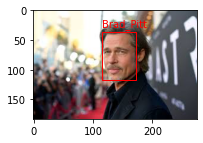

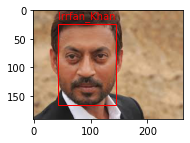

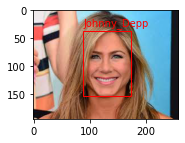

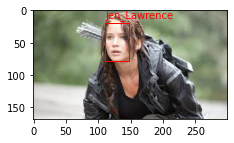

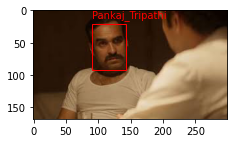

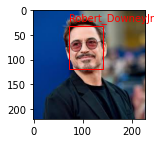

In [55]:
pred=[]
for i in range(len(test_filepaths)): 
    pixels = pyplot.imread(test_filepaths[i])
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    # display faces on the original image
    draw_faces(test_filepaths[i], faces)

In [57]:
from sklearn.metrics import accuracy_score,f1_score

y=['Brad_Pitt','Irrfan_Khan','Jen_Aniston','Jen_Lawrence','Pankaj_Tripathi','Robert_DowneyJr']

print(accuracy_score(y,pred))
print(f1_score(y,pred,average='weighted'))

0.8333333333333334
0.8333333333333334


The accuracy of the inception model is 0.834, i.e.,>0.8

The f1-score for the model is 0.834, i.e., >0.8